在這個單元裡,我們會學習如何使用別人已經建立好的模型. 目前市場上已經有很多工具提供訓練模型的功能, 你只需要準備好資料, 就可以完成你的模型.
例如微軟的[Custom Vision](https://azure.microsoft.com/zh-tw/services/cognitive-services/custom-vision-service/), Amazon的[Rekognition](https://aws.amazon.com/tw/rekognition/), Google的[AutoML](https://cloud.google.com/automl/?hl=zh-tw). 你只需要載入模型檔案就可以直接預測你的測試資料.

因為深度學習的框架不只一種, 本教學僅介紹如何使用 Keras 跟  Tensorflow 的模型檔案.

&copy; 2016 Chih-Chang Yu@CYCU MIT License

首先我們還是要載入需要的函式庫

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras.models import load_model

## 使用Keras的模型
載入Keras模型很簡單, 只要使用 `load_model()` 函數就直接載入完成. 本課程還提供了另一個模型檔案 *my_vgg_model.h5*, 會有比較好的辨識率, 同學可自行載入來比較兩者的不同.

註: 有時候載入模型的過程會當機, 可能的原因是有其他的 ipynb 專案佔住了 gpu 資源, 可以先從 Notebook 的首頁把其他的 process 先關掉就可以正常執行.

In [2]:
# the filepath depends on where you put your model file.
k_model = load_model('model/model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


我們先載入類別的名稱, 之後比較好觀察辨認的結果.

In [3]:
# the filepath depends on where you put your labels file.
with open('model/labels.txt','r') as f:
        labels = (f.read().splitlines())

這邊我們還是先用cifar-10的資料做為測試.

In [9]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

# We only normalize test data because we don't have to train a model here.
X_test = X_test/255

In [13]:
idx = random.randint(1,100)
im = X_test[idx]
k_output = k_model.predict(im.reshape((1,)+im.shape))
k_predict = np.argmax(k_output)

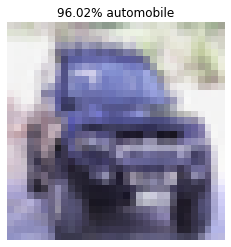

In [14]:
plt.imshow(im)
plt.title('{:.2f}% '.format(k_output[0][k_predict]*100) + labels[k_predict])
plt.axis('off')
plt.show()

## 使用Tensorflow的模型
由於載入 Tensorflow 模型的程式比較複雜, 我們把它包成一個函式, 這樣之後就可以直接寫 `load_tf_model()`來載入模型. 有興趣的同學們可以自行研究一下程式碼.

In [2]:
def load_tf_model(model_filename):

    sess = tf.Session()
    with tf.gfile.FastGFile(model_filename,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def)
        
    return sess

In [3]:
# call load_tf_model() to load tensorflow model.
sess = load_tf_model('model/model.pb')

Instructions for updating:
Use tf.gfile.GFile.


Tensorflow 比較麻煩一點, 需要用到輸入層的名稱跟輸出層的名稱才能進行預測. 我們必須先找出模型的輸入層的名稱,以及模型的輸出層的名稱. 我們要找的名稱需帶有 import 前綴字, 通常模型輸入層的名稱會有 import/Placeholder/input 字樣, 而輸出層會有 Softmax 字樣 (以分類問題來說).  

註: 如果當初模型是用keras來建模後轉換成tensorflow模型, 輸入層的名稱可能會有些不同, 還請讀者留意.

In [4]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

import/hidden1/kernel
import/hidden1/bias
import/output/kernel
import/output/bias
import/RMSprop/lr
import/RMSprop/rho
import/RMSprop/decay
import/RMSprop/iterations
import/training/RMSprop/Variable
import/training/RMSprop/Variable_1
import/training/RMSprop/Variable_2
import/training/RMSprop/Variable_3
import/input_1
import/conv2d/kernel
import/conv2d/bias
import/conv2d/Conv2D/ReadVariableOp
import/conv2d/Conv2D
import/conv2d/BiasAdd/ReadVariableOp
import/conv2d/BiasAdd
import/conv2d/Relu
import/max_pooling2d/MaxPool
import/conv2d_1/kernel
import/conv2d_1/bias
import/conv2d_1/Conv2D/ReadVariableOp
import/conv2d_1/Conv2D
import/conv2d_1/BiasAdd/ReadVariableOp
import/conv2d_1/BiasAdd
import/conv2d_1/Relu
import/max_pooling2d_1/MaxPool
import/flatten/Shape
import/flatten/strided_slice/stack
import/flatten/strided_slice/stack_1
import/flatten/strided_slice/stack_2
import/flatten/strided_slice
import/flatten/Reshape/shape/1
import/flatten/Reshape/shape
import/flatten/Reshape
import/dense/ke

觀察後我們發現輸入層的名字為 `import/input_1`, 輸出層的名字為 `outputs/Softmax`

以下是使用 Tensorflow 的方式進行運測. 

In [25]:
# randomly pick an image
idx = random.randint(1,100)
im = X_test[idx]

# predict
softmax_tensor = sess.graph.get_tensor_by_name('import/outputs/Softmax:0')
tf_output = sess.run(softmax_tensor, {'import/input_1:0': im.reshape((1,)+im.shape)})
tf_predict = np.argmax(tf_output)

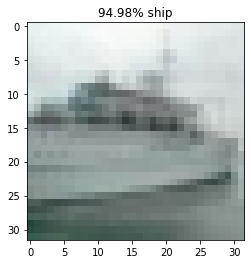

In [26]:
plt.imshow(im)
plt.title('{:.2f}% '.format(tf_output[0][tf_predict]*100) + labels[tf_predict])
plt.show()

你也可以從網路上抓一些圖片來測試模型. Python 中提供了 `requests` 函式庫來取得網路上的資料, 因此我們便利用它來取得測試用的圖片. 這裡我們提供一些可用的連結讓大家練習
- 飛機 https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMxAvTYUR5hSe3Y_V-HB0XmDaG3ZcX-p-CXZaKI-7g-rZH3bCj
- 汽車 https://image.shutterstock.com/image-vector/car-cartoon-sticker-retro-style-260nw-566814880.jpg
- 青蛙 https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSJErznWjCWv70L2VudttjRkSYBiiUmo0uLgWBBNm96ftOYlnZ1kQ
- 卡車 https://target.scene7.com/is/image/Target/GUEST_5ffb9be8-fcc2-4728-87e2-cb021932896a
- 鳥 https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRPLQBnaubH2Z2b9Bw5U0MbZGReBgqsUXPvsrJt8UwEUdqW8Yk
- 鹿 https://huntfish.mdc.mo.gov/sites/default/files/styles/species/public/images/species/deer.jpg

因為建立模型時我們是使用32x32的彩色圖片進行訓練, 因此取得的影像必須先把尺寸調整成 32x32 才能正確地輸入到模型. 你可以自行替換掉`get()`內的字串後執行下面的程式區塊來觀察結果.

註1: 圖片建議盡量找接近正方形的圖片, 這樣比較不會因為尺寸的壓縮而產生物體的變形.  
註2: 這個部分的內容超出了本課程的學習範疇, 有興趣的同學可以自行參考一些相關資料,例如[https://blog.gtwang.org/programming/python-requests-module-tutorial/](https://blog.gtwang.org/programming/python-requests-module-tutorial/)

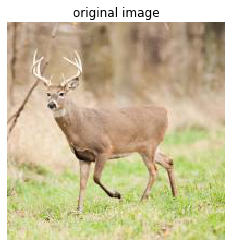

,airplaine,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.0015,0.0000,0.0728,0.0075,0.2660,0.0016,0.6448,0.0057,0.0001,0.0000


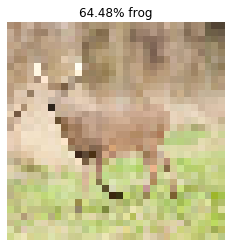

In [9]:
import pandas as pd
from IPython.display import display
from io import BytesIO
import requests

# you can get new images by replacing the string in get() function.
response = requests.get("https://huntfish.mdc.mo.gov/sites/default/files/styles/species/public/images/species/deer.jpg")

if not response.ok:
    print(response)
im_data = response.content
im = Image.open(BytesIO(im_data))

plt.imshow(im)
plt.title('original image')
plt.axis('off')
plt.show()

# The input size of the image should be 32x32x3
im = im.resize((32,32))
im_arr = np.array(im)
# remember to normalize the image
im_arr = im_arr / 255
k_output = k_model.predict(im_arr.reshape((1,)+im_arr.shape))

# this part is just for beautiful printed texts
pd.options.display.float_format = '{:.4f}'.format
df = pd.DataFrame(k_output, columns=labels)
display(df)
k_predict = np.argmax(k_output)
plt.imshow(im_arr)
plt.title('{:.2f}% '.format(k_output[0][k_predict]*100) + labels[k_predict])
plt.axis('off')
plt.show()